# 데이터셋

In [ ]:
import os
## 실제 캐글 계정으로 바꿔야 함!
os.environ['KAGGLE_USERNAME'] = 'ex' # username
os.environ['KAGGLE_KEY'] = 'ex' # key

In [ ]:
!kaggle datasets download -d ckay16/accident-detection-from-cctv-footage

 93% 233M/249M [00:02<00:00, 130MB/s]
100% 249M/249M [00:02<00:00, 114MB/s]


In [ ]:
!pwd

/content


In [ ]:
!unzip -q accident-detection-from-cctv-footage.zip

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

# 데이터셋 분할

In [ ]:
train_datagen = ImageDataGenerator(
  rescale=1./255, # 일반화
  rotation_range=10, # 랜덤하게 이미지를 회전 (단위: 도, 0-180)
  zoom_range=0.1, # 랜덤하게 이미지 확대 (%)
  width_shift_range=0.1,  # 랜덤하게 이미지를 수평으로 이동 (%)
  height_shift_range=0.1,  # 랜덤하게 이미지를 수직으로 이동 (%)
  horizontal_flip=True # 랜덤하게 이미지를 수평으로 뒤집기)
)

test_datagen = ImageDataGenerator(
  rescale=1./255 # 일반화
)


train_gen = train_datagen.flow_from_directory(
  'data/train',
  target_size=(224, 224), # (height, width)
  batch_size=32,
  seed=2021,
  class_mode='categorical',
  shuffle=True
)

test_gen = test_datagen.flow_from_directory(
  'data/test',
  target_size=(224, 224), # (height, width)
  batch_size=32,
  seed=2021,
  class_mode='categorical',
  shuffle=False
)

Found 791 images belonging to 2 classes.
Found 100 images belonging to 2 classes.
<class 'keras.preprocessing.image.DirectoryIterator'>
<class 'tuple'>


In [ ]:
from pprint import pprint
pprint(train_gen.class_indices)

{'Accident': 0, 'Non Accident': 1}


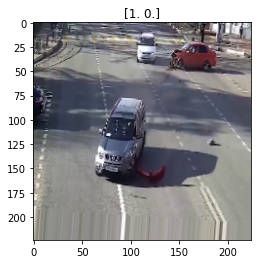

In [ ]:
preview_batch = train_gen.__getitem__(0)

preview_imgs, preview_labels = preview_batch

plt.title(str(preview_labels[8]))
plt.imshow(preview_imgs[8])

# 전이 학습

In [ ]:
from tensorflow.keras.applications import ResNet50

input = Input(shape=(224, 224, 3))

base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=input, pooling='max')

x = base_model.output
# x = Dropout(rate=0.25)(x)
x = Dense(256, activation='relu')(x)
output = Dense(2, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.01), metrics=['acc'])

#model.summary()

94781440/94765736 [==============================] - 0s 0us/step


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.01), metrics=['acc'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


# 학습

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

history = model.fit(
    train_gen,
    validation_data=test_gen, # 검증 데이터를 넣어주면 한 epoch이 끝날때마다 자동으로 검증
    epochs=1, # epochs 복수형으로 쓰기!
    callbacks=[
      ModelCheckpoint('model.h5', monitor='val_acc', verbose=1, save_best_only=True)
    ]
)

25/25 [==============================] - ETA: 0s - loss: 25.7293 - acc: 0.4943
Epoch 1: val_acc improved from -inf to 0.47000, saving model to model.h5
25/25 [==============================] - 44s 1s/step - loss: 25.7293 - acc: 0.4943 - val_loss: 6328457680125952.0000 - val_acc: 0.4700


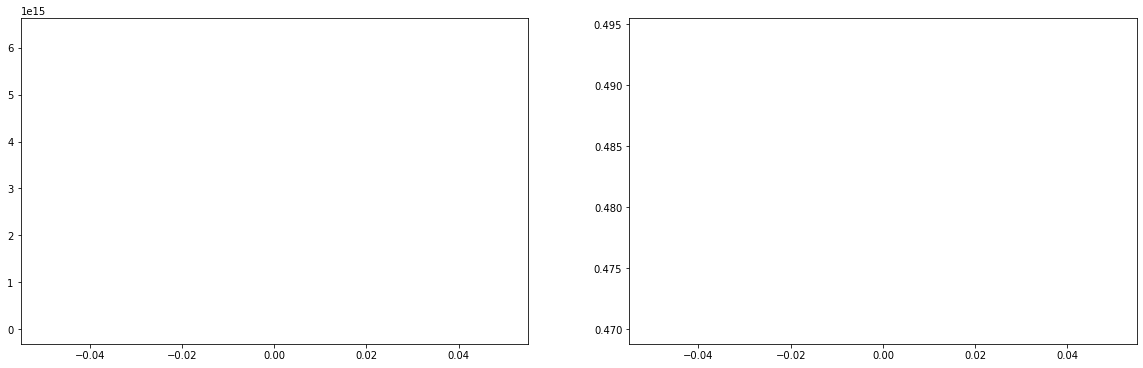

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(20, 6))
axes[0].plot(history.history['loss'])
axes[0].plot(history.history['val_loss'])
axes[1].plot(history.history['acc'])
axes[1].plot(history.history['val_acc'])

In [ ]:
from tensorflow.keras.models import load_model

model = load_model('model.h5')

print('Model loaded!')

Model loaded!


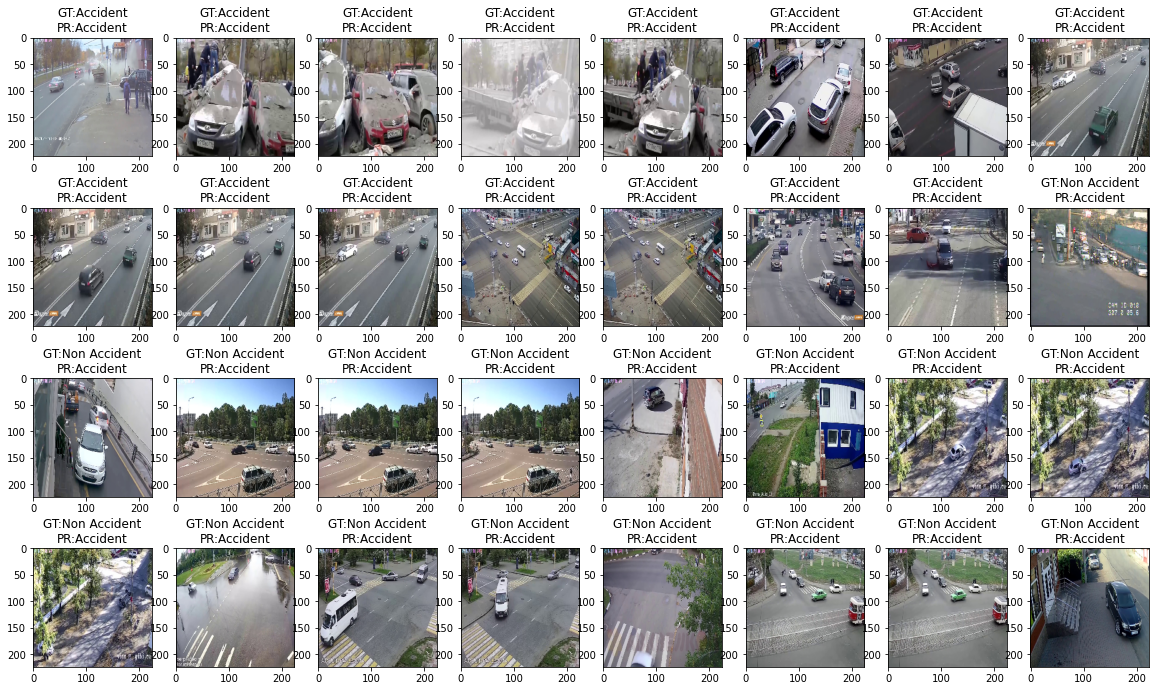

In [ ]:
test_imgs, test_labels = test_gen.__getitem__(1)

y_pred = model.predict(test_imgs)

classes = dict((v, k) for k, v in test_gen.class_indices.items())

fig, axes = plt.subplots(4, 8, figsize=(20, 12))

for img, test_label, pred_label, ax in zip(test_imgs, test_labels, y_pred, axes.flatten()):
  test_label = classes[np.argmax(test_label)]
  pred_label = classes[np.argmax(pred_label)]

  ax.set_title('GT:%s\nPR:%s' % (test_label, pred_label))
  ax.imshow(img)